In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle
from functions import get_var_hist,simulate_traj,get_x2_var, get_steady_mean,get_theo_var_l
from setup import setup_matplotlib

setup_matplotlib()

np.random.seed(42)

# var

In [4]:
k = 1
s = 1
D = s**2/2
max_t = 6

N_p = 1_000

N_loop = 20

def force(x,*args):
     return -k*x



ltaus = np.array([0,0.02,0.05]) # np.concatenate(([0,0.05], np.arange(0.2,2.2,0.2) ))
ntaus = np.logspace(0.6,1.5,10,dtype = int)
sim_vars = np.empty((len(ntaus),len(ltaus),2))

In [5]:
for j, ntau in enumerate(tqdm(ntaus)):
    for i,ltau in enumerate(tqdm(ltaus, leave = False)): 
        ldt = ltau/ntau if ltau > 0 else 0.01/ntau
        N_t = max(int(max_t/ldt), 30)
        if ltau > 0:
            pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau), ntau=ntau, s=s, dt=ldt,border=0, force=force)
        else:
            pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau), ntau=0, s=s, dt=ldt,border=0, force=force)
        sim_var = np.var(pos, axis = 1)
        mean_vars = np.mean(sim_var[:,-ntau*2:], axis = 1)

        #m_sim_var = get_steady_mean(sim_var)
        sim_vars[j,i] = (np.mean(mean_vars), np.std(mean_vars)/np.sqrt(N_loop)) #m_sim_var if m_sim_var else (np.nan,np.nan)

  0%|          | 0/10 [00:00<?, ?it/s]
































 10%|█         | 1/10 [00:05<00:50,  5.61s/it]











































 20%|██        | 2/10 [00:14<00:58,  7.30s/it]





























 30%|███       | 3/10 [00:21<00:51,  7.38s/it]

































 40%|████      | 4/10 [00:29<00:45,  7.66s/it]











































































 50%|█████     | 5/10 [00:46<00:53, 10.80s/it]














































































 60%|██████    | 6/10 [01:03<00:52, 13.18s/it]











































































































 70%|███████   | 7/10 [01:27<00:49, 16.53s/it]















































































































































 80%|████████  | 8/10 [01:57<00:41, 20.91s/it]























































































In [8]:
exact_sol = get_x2_var(ltaus, k, s)

(0.49, 0.55)

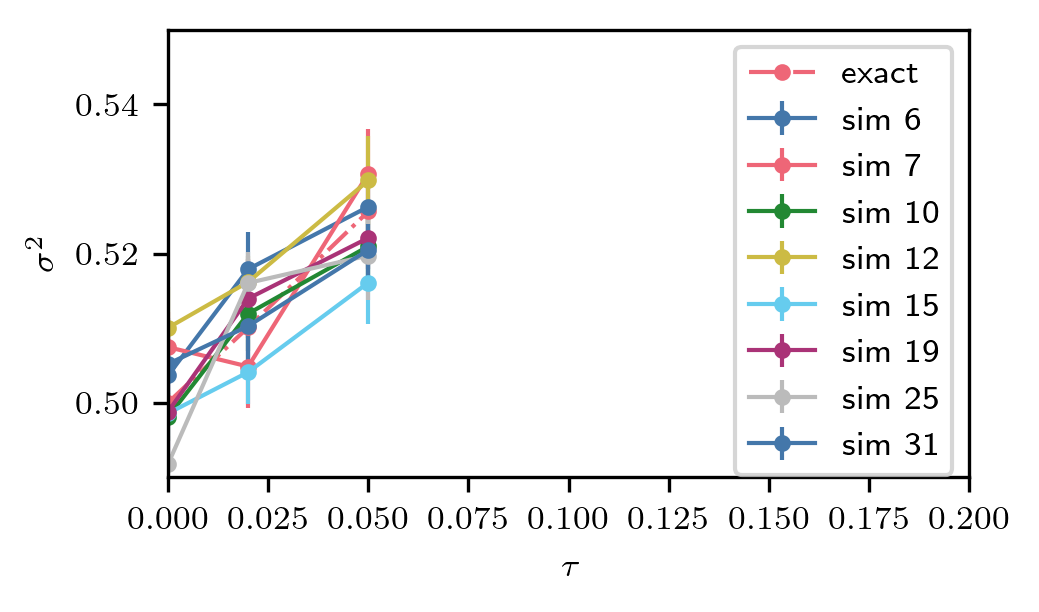

In [9]:
#plt.figure(figsize=(7,3))
ax = plt.subplot(111)
for ntau, sim_var_one_ntau in zip(ntaus[2::1],sim_vars[2::1]):
    plt.errorbar(ltaus,sim_var_one_ntau[:,0], yerr = sim_var_one_ntau[:,1], ls='-', marker = '.',label=f'sim {ntau}')

plt.plot(ltaus[ltaus < np.pi/2/k],exact_sol[ltaus < np.pi/2/k] ,'.-.',label='exact')

#plt.ylim(3e-1,7)
plt.xlim(0,2.1)
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
y = 4e-1
#plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
#plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
# plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')


plt.tight_layout()

plt.xlim(0,0.2)
plt.ylim(0.49,0.55)

In [11]:
for ntau, sim_var_one_ntau in zip(ntaus,sim_vars):
    plt.plot(ltaus[ltaus < np.pi/2/k],sim_var_one_ntau[ltaus < np.pi/2/k,0] / exact_sol[ltaus < np.pi/2/k] ,'.-.', label=ntau)
    
    
plt.xlim(-0.1,2)
plt.vlines([1/np.e /k],*plt.ylim(), color='black')
y = 0.5
plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')


plt.xlabel(r'$\tau$')
plt.ylabel('Deviation')
plt.legend()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12 but corresponding boolean dimension is 11

## ntau = 12 seems to be alreday quiete optimal

# rate

In [2]:
k = 1
s = 0.35
border = 1
max_t = 10
ntau = 3

D = s**2/2


f = 4
N_p = 2_000
N_loop = 10
eq_perc = 0.75
eq_f = 0.75

border = 1
N_x_border = 6.5
dx = border/N_x_border
sb = 17.5*dx
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)


def cusp_force(x, thresh = 1e-7):
    if x < -thresh:
        return -k*(x+border)
    elif x > thresh:
        return -k*(x-border)
    else:
        return 0
force = np.vectorize(cusp_force)




ltaus = np.arange(0,2.2,0.2) #np.concatenate(([0.05], np.arange(0.2,2.2,0.2) ))
fs = [3,4,5,6,8,10,12]#np.unique(np.logspace(0,1,5,dtype = int))

test_ts = np.linspace(0,max_t, 4000)
exact_eqtimes = [test_ts[np.argmin((get_theo_var_l(test_ts,ltau,D) - eq_perc*get_x2_var(ltau, k, s))**2)] for ltau in ltaus]

In [3]:
fs

[3, 4, 5, 6, 8, 10, 12]

In [4]:
sim_rates = np.empty((len(fs),len(ltaus),2))

for j, f in enumerate(tqdm(fs)):
    for i,ltau in enumerate(tqdm(ltaus)): 
        ldt = ltau/ntau if ltau < 0 else 0.01
        q_f = np.log(1-eq_f)/np.log(1-eq_perc)
        rel_time = q_f*exact_eqtimes[i]

        N_t = max(int(2*rel_time/ldt),int(max_t/ldt), 30)
        sim_ts = np.arange(0,f*N_t+ntau*f)*ldt/f-ltau

        pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=border, force=force)

        sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
        sim_sur = np.sum(sim_hists[:,:,x_s < 0], axis = 2)/np.sum(sim_hists, axis = 2)

        sim_cond = (sim_ts > rel_time) * (sim_sur - 1/2 > 0.05)

        sim_rate = [-np.mean(np.diff(np.log(2*sim_sur[i,this_sim_cond]-1))/ldt*f) for i,this_sim_cond in enumerate(sim_cond)]
        sim_rates[j,i] = (np.mean(sim_rate), np.std(sim_rate)/np.sqrt(N_loop))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for j,f in enumerate(fs):
    plt.errorbar(ltaus, *sim_rates[j].T, label = f)
plt.yscale('log')
plt.legend()

## f = 3 ntau = 3 seems to be alreday quiete optimal